# KI - Projekt: Evidenztheorie

Anhand von Sensor-Daten soll kassifiziert werden, ob es sich bei dem vermessenen Objekt um einen PKW, einen LKW, ein Motorrad oder ein Fahrrad handelt.
<br>
Folgende Kategorien werden unterschieden: <br>

| <b>KFZ-Art<b> | <b>Geschwindigkeit</b> | <b>Beschleunigung</b>| <b>Höhe</b> | <b>Breite</b> |
| --------------|------------------------|----------------------|-------------|-------------- |
| <b>Fahrrad</b> | Langsam | - | hoch | schmal |
| <b>PKW</b> | Mittel | - | flach | breit |
| <b>LKW</b> | Mittel | - | hoch | breit |
| <b>Motorrad</b> | Mittel | Stark | hoch | schmal |

- Mittlere Geschwindigkeit zwischen 50 und 90 km/h.

## Schritte / Methoden:
1. Daten einlesen und explorieren.
2. Grenzwerte für 'hoch', 'flach', 'starke Beschleunigung', ... berechnen.
3. Einzelne Datensequenzen einlesen und Fahrzeugart mithilfe von `python_evidence`-Framework bestimmen.
  1. Werte (Geschw., Beschl., ...) bestimmen.
  2. Evidenz-Messung (+ Wahrscheinlichkeiten) festlegen.
  3. Fahrzeugart bestimmen.

## Hinweis
- Sensoren arbeiten auf hohen Entfernungen ungenauer:
  - Mögliche Fehlerquelle, möglicherweise korrigieren / einberechnen.

In [2]:
# Imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

from python_evidence.dempster_handler import DempsterHandler, Measure
from utils import load_data, change_data, get_velocity, get_acceleration, save_data_dict, get_dimensions

# Schritt 1: Daten einlesen und explorieren

--------------------------------------------------

Daten befinden sich in Form von CSV Dateien im [data](/data)-Ordner.

Sie bestehen aus jeweils einzelnen Mess-Sequenzen für ein Fahrzeug. Die Messdaten bestehen aus:
- t
  - Zeitpunkte (Messung alle 100ms)
- Eigengeschwindigkeit(m/s)
- Bbox_Breite
- Bbox_Höhe
- Bbox_links_unten_y
- Abstand(m)

In [3]:
"""
TODO:
    * Daten laden / explorieren.

    * Geschwindigkeiten von m/s in km/h.
    * Beschleunigung.
    * Höhe / Breite.
    
    * Grenzwerte berechnen.

    * Evidenztheorie für einzelne CSV Dateien.
"""

DATA_FOLDER = Path("data")
CSV_FILES = ["DPE15_1.csv", "DPE15_2.csv", "DPE15_3.csv", "DPE15_4.csv", 
             "DPE16_1.csv", "DPE16_2.csv", "DPE16_3.csv", "DPE16_4.csv"]

for ix, path in enumerate(CSV_FILES):
    CSV_FILES[ix] = DATA_FOLDER.joinpath(path)

# Daten laden.
data_dict = load_data(CSV_FILES)

# Datensatz explorieren.
df = data_dict["DPE15_1"]
display(df)

print(df.info())

"""
TODO:
    * Eigengeschwindigkeit zu floats
    * Gechwindigkeit m/s in km/h.
    * Abstand(m) zu floats.
    * Beschleunigung.
    * Höhe / Breite.
"""
change_data(data_dict)
print("\n\nUsing files:\n")
# Geschwindigkeiten / Acceleration vom anderen Fahrzeug
for path, df in data_dict.items():
    print(path)
    print("--------------------------")
    get_velocity(df)
    get_dimensions(df)
    print("\n")

print(data_dict["DPE16_2"].info())
display(data_dict["DPE16_2"])


,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m)
0,0,"16,1",61,121,142,71
1,"0,1","16,1",64,128,141,"70,5"
2,"0,2",16,64,127,138,69
3,"0,3","16,1",66,131,138,69
4,"0,4",16,67,134,137,"68,5"
...,...,...,...,...,...,...
99,"9,9","16,1",181,362,22,11
100,10,"16,2",183,366,20,10
101,"10,1","16,1",183,365,18,9
102,"10,2","16,1",230,374,18,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   t                          104 non-null    object
 1   Eigengeschwindigkeit(m/s)  104 non-null    object
 2   Bbox_Breite                104 non-null    int64 
 3   Bbox_Höhe                  104 non-null    int64 
 4   Bbox_links_unten_y         104 non-null    int64 
 5   Abstand(m)                 104 non-null    object
dtypes: int64(3), object(3)
memory usage: 5.0+ KB
None


Using files:

DPE15_1
--------------------------


DPE15_2
--------------------------


DPE15_3
--------------------------


DPE15_4
--------------------------


DPE16_1
--------------------------


DPE16_2
--------------------------


DPE16_3
--------------------------


DPE16_4
--------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (tot

,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m),v(m/s),v(km/h),width,height
0,0.0,22.0,304,226,87,43.5,22.05,79.38,1.955,1.565
1,0.1,22.1,276,227,87,43.5,22.05,79.38,1.815,1.570
2,0.2,22.1,279,230,87,43.5,22.10,79.56,1.830,1.585
3,0.3,22.0,287,236,86,43.0,17.05,61.38,1.865,1.610
4,0.4,22.2,283,233,86,43.0,22.10,79.56,1.845,1.595
...,...,...,...,...,...,...,...,...,...,...
99,9.9,22.0,106,87,157,78.5,17.10,61.56,1.315,1.220
100,10.0,22.1,104,85,159,79.5,32.05,115.38,1.315,1.220
101,10.1,22.0,126,77,162,81.0,37.05,133.38,1.440,1.195
102,10.2,22.1,101,83,161,80.5,17.05,61.38,1.310,1.220


Moving data of vehicles


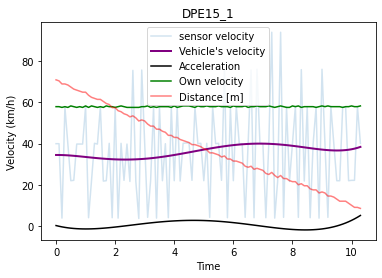

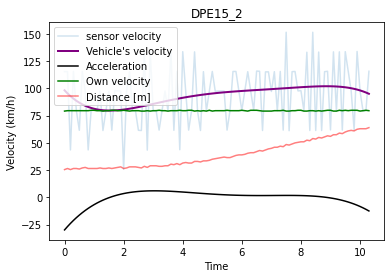

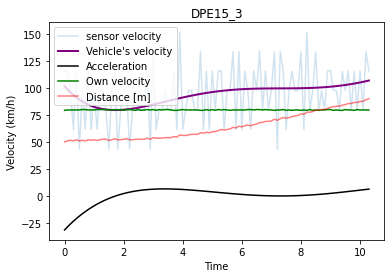

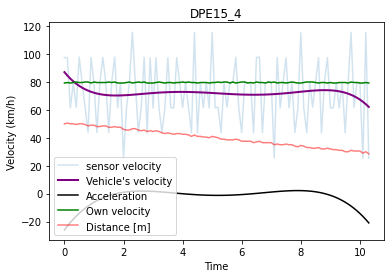

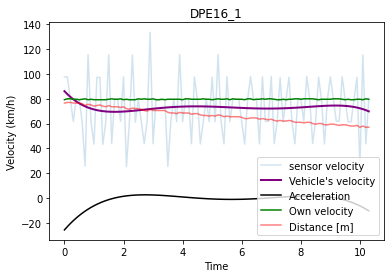

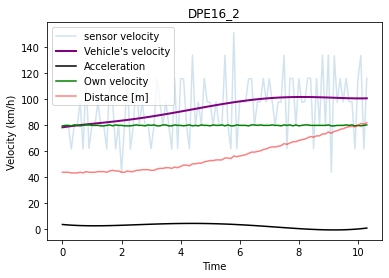

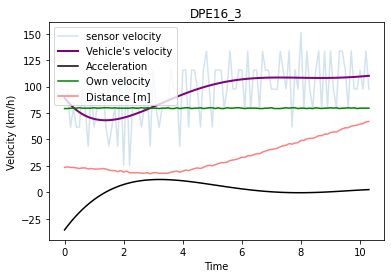

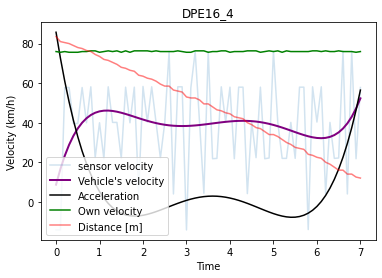

In [7]:
print("Moving data of vehicles")
# plot calculated velocity and acceleration
for path, df in data_dict.items():
    plt.title(path)
    plt.ylabel("Velocity (km/h)")
    plt.xlabel("Time")
    velocity_key = "v(km/h)"

    # Real plots
    plt.plot(df["t"], df[velocity_key], alpha=0.2, label="sensor velocity")

    degree_of_graph = 5
    # optimize calculated velocity, as it is scattered
    velocity_model = np.poly1d(np.polyfit(df["t"], df[velocity_key], degree_of_graph))
    # plot optimized velocity
    plt.plot(df["t"], velocity_model(df["t"]), linewidth=2, color="purple", label="Vehicle's velocity")
    
    df["v(km/h) polyfit"] = velocity_model(df["t"])

    # call method which extends data frame by the acceleration
    get_acceleration(df, velocity_model)
    # plot acceleration
    plt.plot(df["t"], df["a(km/h^2)"], color="black", label="Acceleration")

    # plot the velocity of the data recording vehicle
    plt.plot(df["t"], df["Eigengeschwindigkeit(m/s)"]  * 3.6, color="green", label="Own velocity")

    plt.plot(df["t"], df["Abstand(m)"], color="red", alpha=0.5, label="Distance [m]")
    plt.legend()
    plt.show()

# Save data in dictionary for further calculations
save_data_dict(data_dict, Path("updated_data"))

DPE15_1
_______________________________________
Velocity:     min: 32.241833172157044   max: 39.99136178949391
Acceleration: min: -1.9628057453475334  max: 5.0649679961258
Height : Width ratio 1.5956940033626006


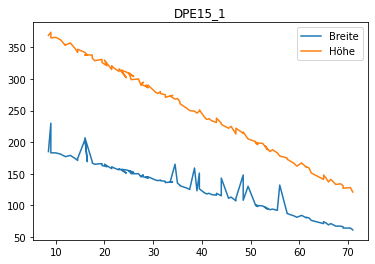




DPE15_2
_______________________________________
Velocity:     min: 79.69224772307527   max: 102.00547678003407
Acceleration: min: -29.872863194122672  max: 6.0080216389366825
Height : Width ratio 1.1730264973778637


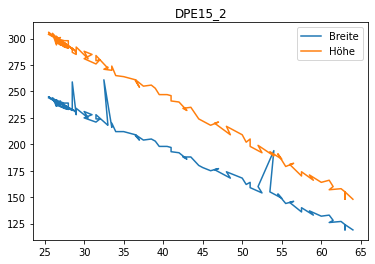




DPE15_3
_______________________________________
Velocity:     min: 79.46692937230029   max: 106.7546756256077
Acceleration: min: -31.2916723187062  max: 6.609577433815058
Height : Width ratio 0.8952807869505665


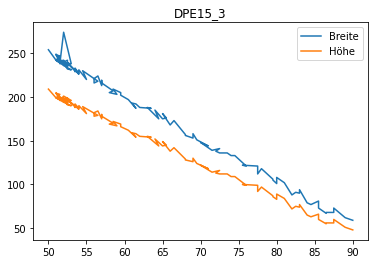




DPE15_4
_______________________________________
Velocity:     min: 62.07692266065757   max: 86.9976416544095
Acceleration: min: -25.995093820885867  max: 2.1705748598611407
Height : Width ratio 1.5085864668361657


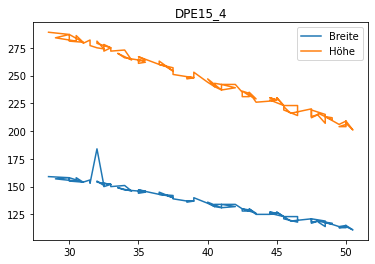




DPE16_1
_______________________________________
Velocity:     min: 69.43598786121102   max: 86.09821529685841
Acceleration: min: -25.7112432001267  max: 2.5527801695419043
Height : Width ratio 1.0435777277591232


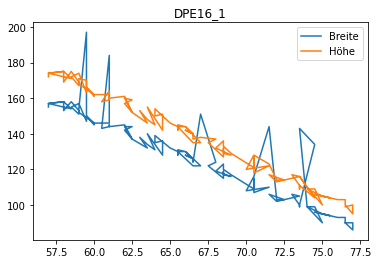




DPE16_2
_______________________________________
Velocity:     min: 80.75394734980762   max: 101.40327974199121
Acceleration: min: -0.8390103445769062  max: 4.160868284713044
Height : Width ratio 0.8757060518731988


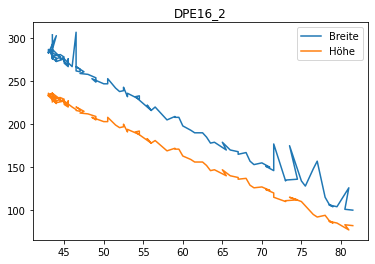




DPE16_3
_______________________________________
Velocity:     min: 68.10622304948872   max: 110.16778099448905
Acceleration: min: -35.62563922409232  max: 12.072067232542892
Height : Width ratio 1.0203779069767442


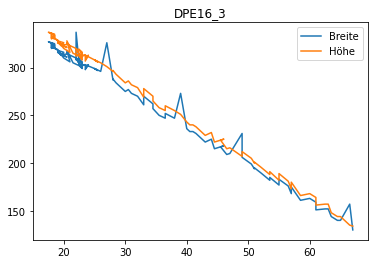




DPE16_4
_______________________________________
Velocity:     min: 32.15825548278856   max: 52.30255672732508
Acceleration: min: -7.823825066399181  max: 85.72825824366221
Height : Width ratio 1.5054317931793184


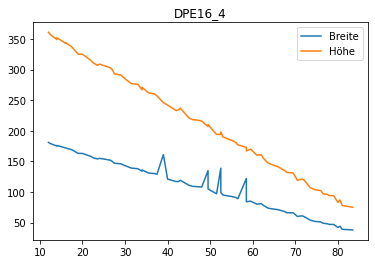

In [9]:
# Plot height and width of the vehicle
for path, df in data_dict.items():
    plt.title(path)
    
    plt.plot(df["Abstand(m)"], df["Bbox_Breite"], label="Breite")
    plt.plot(df["Abstand(m)"], df["Bbox_Höhe"], label="Höhe")

    height, width, distance = np.mean(df["Bbox_Höhe"]), np.mean(df["Bbox_Breite"]), np.mean(df["Abstand(m)"])
    # calculate ratio of height to width
    height_width_ratio = height / width
    print(path)
    print("_______________________________________")
    print("Velocity:     min:", df.iloc[10:]["v(km/h) polyfit"].min(), "  max:", df["v(km/h) polyfit"].max())
    print("Acceleration: min:", df["a(km/h^2)"].min(), " max:", df["a(km/h^2)"].max())
    
    # print height to width ratios
    print("Height : Width ratio", np.mean(df["height"]) / np.mean(df["width"]))

    plt.legend()
    plt.show()
    print("\n\n")

Velocity is lower 50 km/h
Low acceleration
height / width:  1.5956940033626006
High and narrow
Correcting with  1.5384615384615383
Auto 0.11538461538461536 0
LKW 0.46153846153846145 0.23076923076923073
Motorrad 0.23076923076923073 0
Fahrrad 0.7692307692307692 0.5384615384615383


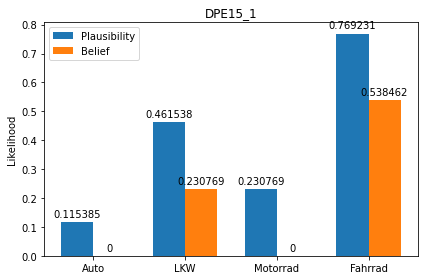




Velocity is greater 50 km/h
High acceleration
height / width:  1.1730264973778637
High and narrow
Auto 0.22500000000000003 0
LKW 0.45000000000000007 0
Motorrad 1.0 0.55
Fahrrad 0.18000000000000002 0


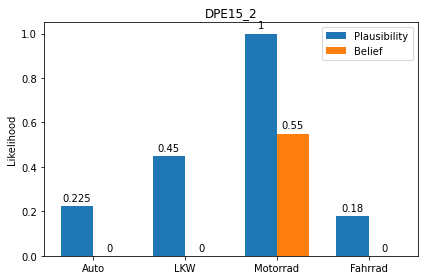




Velocity is greater 50 km/h
High acceleration
height / width:  0.8952807869505665
flat and wide
Correcting with  1.6260162601626016
Auto 0.7317073170731707 0.5121951219512195
LKW 0.21951219512195125 0
Motorrad 0.48780487804878053 0.2682926829268293
Fahrrad 0.0878048780487805 0


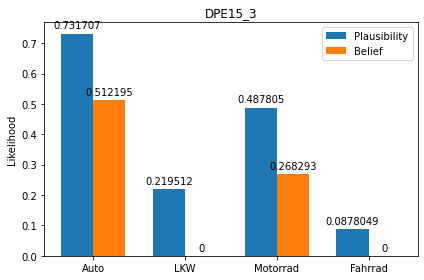




Velocity is greater 50 km/h
High acceleration
height / width:  1.5085864668361657
High and narrow
Auto 0.22500000000000003 0
LKW 0.45000000000000007 0
Motorrad 1.0 0.55
Fahrrad 0.18000000000000002 0


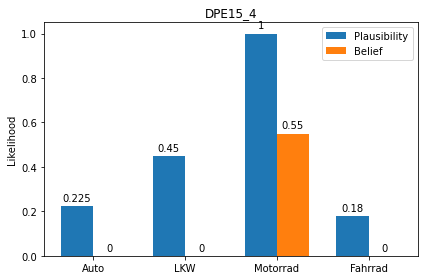




Velocity is greater 50 km/h
High acceleration
height / width:  1.0435777277591232
High and narrow
Auto 0.22500000000000003 0
LKW 0.45000000000000007 0
Motorrad 1.0 0.55
Fahrrad 0.18000000000000002 0


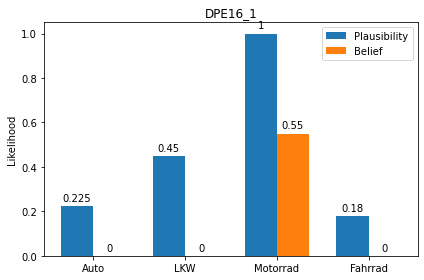




Velocity is greater 50 km/h
Low acceleration
height / width:  0.8757060518731988
flat and wide
Correcting with  1.5384615384615383
Auto 0.769230769230769 0.5384615384615383
LKW 0.46153846153846145 0.23076923076923073
Motorrad 0.23076923076923073 0
Fahrrad 0.0923076923076923 0


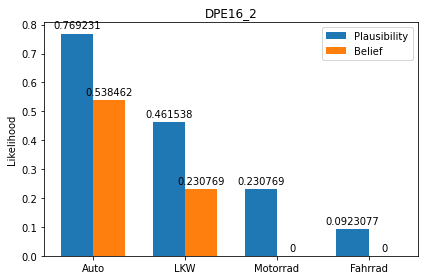




Velocity is greater 50 km/h
High acceleration
height / width:  1.0203779069767442
High and narrow
Auto 0.22500000000000003 0
LKW 0.45000000000000007 0
Motorrad 1.0 0.55
Fahrrad 0.18000000000000002 0


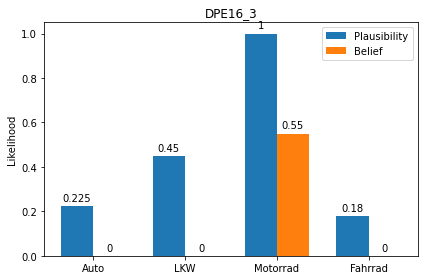




Velocity is lower 50 km/h
High acceleration
height / width:  1.5054317931793184
High and narrow
Correcting with  1.6260162601626016
Auto 0.10975609756097561 0
LKW 0.21951219512195122 0
Motorrad 0.4878048780487805 0.2682926829268293
Fahrrad 0.7317073170731707 0.5121951219512195


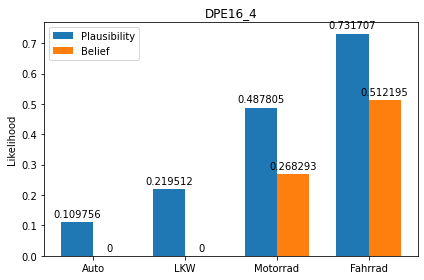

In [16]:
def get_max_range_by_criterion(arr: list, criterion):
    """
    Get maximal number of elements fullfilling criterion in arr in a row.
    """
    scope = 0
    return_value = 0
    left_selected = False
    for element in arr:
        if criterion(element):
            scope += 1
            left_selected = True
        if (not criterion(element)) and left_selected:
            if scope > return_value:
                return_value = scope
            left_selected = False
    if scope > return_value:
                return_value = scope
    return return_value
        

def get_acceleration_limit(data_dict: dict, limit: float):
    """determines upper and lower limit of acceleration values, to
        check whether a vehicle has a high acceleration"""
    all_accelerations = []
    for _, df in data_dict.items():
        df_a = df["a(km/h^2)"]
        lower_limit = 0
        upper_limit = len(df_a)
        # check if distance between vehicles decreases and adjust limit
        if df["Abstand(m)"].iloc[0] < df["Abstand(m)"].iloc[1]:
            upper_limit -= 10
        else:
            lower_limit = 10
        for acc in df_a.iloc[lower_limit:upper_limit]:
            if acc > 85:
                print(_)
            # append absolute value of acceleration to acceleration list
            all_accelerations.append(abs(acc))
    # return the requested percentile
    return np.percentile(sorted(all_accelerations), [limit*100])[0]

ACCELERATION_LIMIT_UPPER = get_acceleration_limit(data_dict, limit=0.9)
ACCELERATION_LIMIT_LOWER =  get_acceleration_limit(data_dict, limit=0.1)

def estimate_vehicle_type(df, title):
    """ estimate type of vehicle, based on bounding box, speed and acceleration"""
    handler = DempsterHandler(["Auto", "LKW", "Motorrad", "Fahrrad"])

    # check type of vehicle on basis of its velocity
    range_speed_greater_50 = get_max_range_by_criterion(df["v(km/h) polyfit"], lambda x : x >= 50)
    # at a speed greater than 50 it is unlikely to deal with a bicycle
    if range_speed_greater_50 >= 10:
        print("Velocity is greater 50 km/h")
        handler.add_measure([
            Measure(["Auto", "LKW", "Motorrad"], 0.6)
        ])
    else:
        print("Velocity is lower 50 km/h")
        handler.add_measure([
            Measure(["Fahrrad"], 0.7)
        ])

    # check type of vehicle on basis of its acceleration
    # a high acceleration could indicate a motorcycle
    if get_max_range_by_criterion(df["a(km/h^2)"],
                                 lambda x : abs(x) >= ACCELERATION_LIMIT_UPPER) >= 5:
        print("High acceleration")
        handler.add_measure([
            Measure(["Motorrad"], 0.55)
        ])
    elif get_max_range_by_criterion(df["a(km/h^2)"],
                                   lambda x : abs(x) <= ACCELERATION_LIMIT_LOWER) >= 5:
        print("Low acceleration")
        handler.add_measure([
            Measure(["LKW"], 0.5)
        ])

    # Höhe : Breite
    height_mean, width_mean = np.mean(df["height"]), np.mean(df["width"]) 
    height_width_ratio = height_mean / width_mean
    print("height / width: ", height_width_ratio)
    if height_width_ratio >= 1.0:
        print("High and narrow")
        handler.add_measure([
            Measure(["Motorrad", "Fahrrad", "LKW"], 0.5)
        ])
    else:
        print("flat and wide")
        handler.add_measure([
            Measure(["Auto"], 0.7)
        ])
    
    # Akkumulieren und Plausibilitäten berechnen.
    accumulate = handler.accumulate()
    pls = []
    blfs = []
    categories = handler.categories()
    for category in categories:
        p = handler.plausibility(accumulate, category)
        b = handler.belief(accumulate, category)
        pls.append(p)
        blfs.append(b)
        print(category, p, b)
   
    width = 0.35
    x = np.arange(len(categories))
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pls, width, label="Plausibility")
    rects2 = ax.bar(x + width/2, blfs, width, label="Belief")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Likelihood")
    ax.set_title(title)
    ax.set_xticks(x, categories)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    print("\n\n")

# WANTED
for name, df in data_dict.items():
    estimate_vehicle_type(df, name)